<a href="https://colab.research.google.com/github/Pakyy/NLP-Project---MT-en-it/blob/main/nlp_test_funz_comet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES AND DATA**

In [ ]:
!pip install tqdm
!pip install keras
!pip install tensorflow
!pip install translate-toolkit
!pip install evaluate
!pip install nltk rouge-score
!pip install unbabel-comet;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
 

In [ ]:
from google.colab import drive
from translate.storage import tmx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from tqdm import tqdm
from evaluate import load
import xml.etree.ElementTree as ET;

In [ ]:
import pytorch_lightning as pl
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)  # Mostra solo messaggi di errore

In [ ]:
# Monta Google Drive per caricare il file
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/en-it.tmx"
sentence_pairs = []

# Open the file in read mode
with open(file_path, 'rb') as f:
  tmx_file = tmx.tmxfile(f)

# Iterate through the translation units and store sentence pairs
for unit in tmx_file.units:
    source_text = unit.source
    target_text = unit.target
    sentence_pairs.append((source_text, target_text))

# Create a DataFrame from the sentence pairs
df = pd.DataFrame(sentence_pairs, columns=['Source', 'Target']);

Mounted at /content/drive


# **PRE - PROCESSING**

In [ ]:
# Funzione di pulizia per rimuovere caratteri speciali e gestire gli accenti
def clean_text(text):
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-ZàèéìòùÀÈÉÌÒÙçÇ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Applichiamo la pulizia su Source e Target
df['Source_clean'] = df['Source'].apply(clean_text)
df['Target_clean'] = df['Target'].apply(clean_text)

# Rimuove le righe con frasi vuote
df = df[df['Source_clean'].str.strip() != '']
df = df[df['Target_clean'].str.strip() != '']

# Rimuove frasi troppo corte (esempio: meno di 3 parole)
df = df[df['Source_clean'].apply(lambda x: len(x.split()) >= 3)]
df = df[df['Target_clean'].apply(lambda x: len(x.split()) >= 3)]

# Verifica la presenza di eventuali valori nulli
print(df.isnull().sum())

# Rimozione duplicati
df.drop_duplicates(subset=['Source_clean', 'Target_clean'], inplace=True)

# Verifica dei risultati puliti
df[['Source_clean', 'Target_clean']].head(10)

Source          0
Target          0
Source_clean    0
Target_clean    0
dtype: int64


,Source_clean,Target_clean
1,There s a tight and surprising link between th...,Esiste uno stretto e sorprendente legame tra l...
2,fish health mission blue oceans science,fish health mission blue oceans science
4,Stephen Palumbi Following the mercury trail,Stephen Palumbi Sulle tracce del mercurio
5,It can be a very complicated thing the ocean,Può essere una cosa davvero complicata l oceano
6,And it can be a very complicated thing what hu...,E può essere una cosa davvero complicata la sa...
7,And bringing those two together might seem a v...,E mettere insieme queste due cose può sembrare...
8,And those simple themes aren t really themes a...,E questi semplici aspetti non riguardano le co...
9,And I m going to start with this one If momma ...,E vorrei partire da questa mamma infelice tutt...
10,We know that right We ve experienced that,Lo sappiamo tutti giusto Ci siamo passati tutti
11,And if we just take that and we build from the...,E se prendiamo questa idea e partiamo da qui p...


# **EDA**

## *Sentence length distribution*

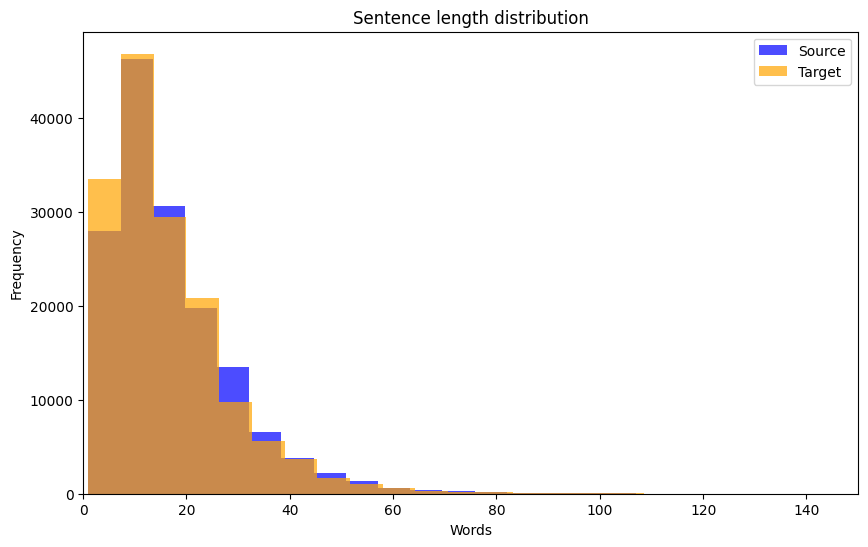

In [ ]:
# Calcola la lunghezza delle frasi
df['source_length'] = df['Source'].apply(lambda x: len(x.split()))
df['target_length'] = df['Target'].apply(lambda x: len(x.split()))

# Plot della distribuzione delle lunghezze
plt.figure(figsize=(10, 6))
plt.hist(df['source_length'], bins = 100, alpha=0.7, label='Source', color = "blue")
plt.hist(df['target_length'], bins = 100, alpha=0.7, label='Target', color =  "orange")
plt.legend(loc='upper right')
plt.title('Sentence length distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xlim(0, 150)
plt.show()

## *Most frequent words*

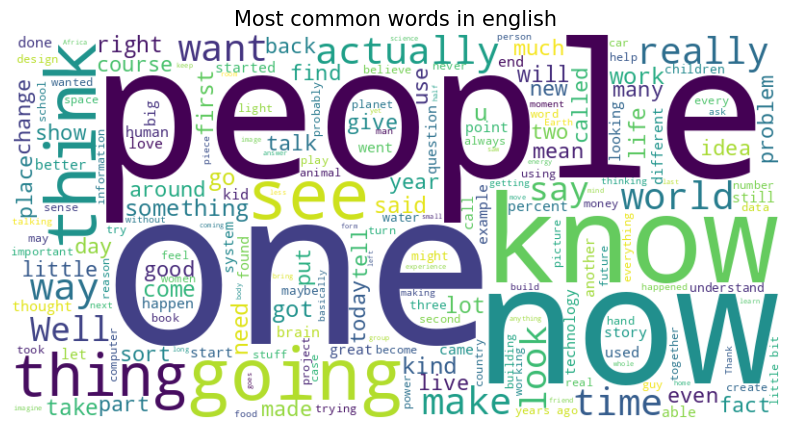

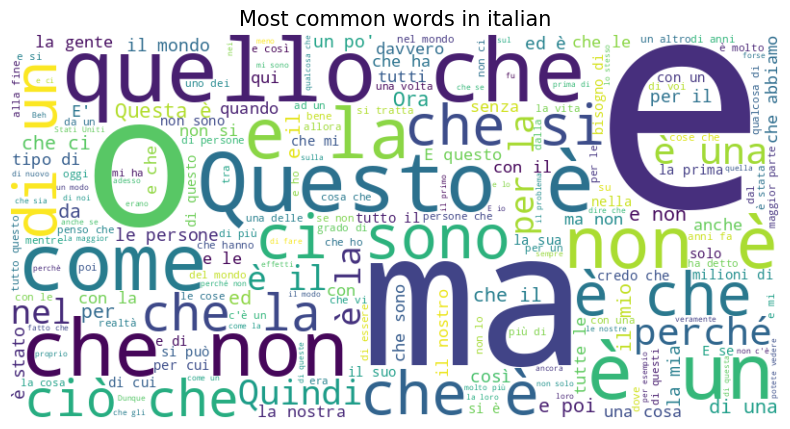

In [ ]:
# Funzione per ottenere le parole più comuni
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=15)
    plt.axis('off')
    plt.show()

# Parole più comuni nelle frasi di Source
source_words = df['Source'].str.split().explode()
plot_wordcloud(source_words, 'Most common words in english')

# Parole più comuni nelle frasi di Target
target_words = df['Target'].str.split().explode()
plot_wordcloud(target_words, 'Most common words in italian')

## *Source - Target Words Ratio*

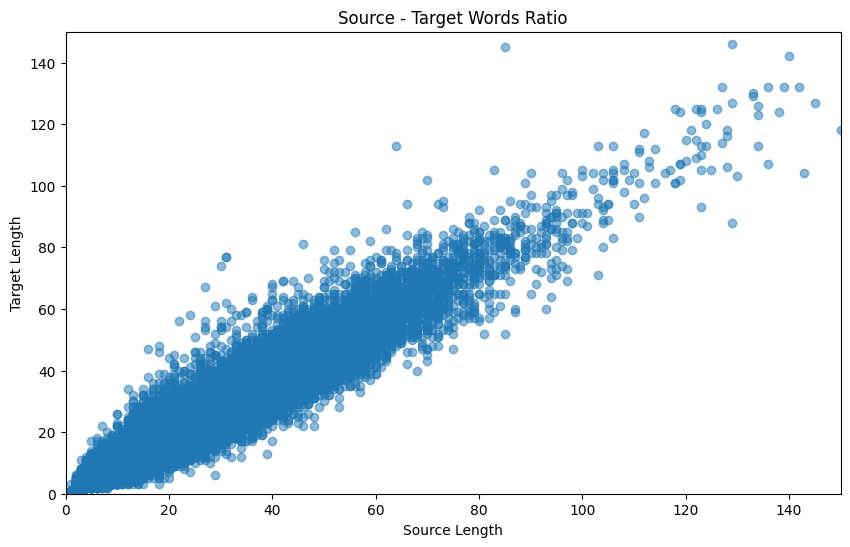

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['source_length'], df['target_length'], alpha=0.5)
plt.title('Source - Target Words Ratio')
plt.xlabel('Source Length')
plt.ylabel('Target Length')
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

### Removing too long sentences

In [ ]:
# Rimuove frasi troppo lunghe (più di 96 parole)
df = df[df['Source'].apply(lambda x: len(x.split()) <= 96)]
df = df[df['Target'].apply(lambda x: len(x.split()) <= 96)]
# Stampa la lunghezza del dataset
print(f"Dataset length after the removal of too long sentences: {len(df)}")

Dataset length after the removal of too long sentences: 153535


# **TOKENIZATION**

In [ ]:
from transformers import MarianTokenizer
from sklearn.model_selection import train_test_split
import torch

# Initialize tokenizer
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-it')

# Step 1: Split the data before tokenizing to keep references to the original sentences
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

# Step 2: Tokenize each split independently to avoid handling tensor splits
train_source_tokens = tokenizer(train_df['Source_clean'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=96)
train_target_tokens = tokenizer(train_df['Target_clean'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=96)
test_source_tokens = tokenizer(test_df['Source_clean'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=96)
test_target_tokens = tokenizer(test_df['Target_clean'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=96)

# Step 3: Assign tokenized IDs and attention masks for both source and target languages
train_source_ids, train_source_mask = train_source_tokens['input_ids'], train_source_tokens['attention_mask']
train_target_ids, train_target_mask = train_target_tokens['input_ids'], train_target_tokens['attention_mask']
test_source_ids, test_source_mask = test_source_tokens['input_ids'], test_source_tokens['attention_mask']
test_target_ids, test_target_mask = test_target_tokens['input_ids'], test_target_tokens['attention_mask']

# Step 4: Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_source_ids, test_source_ids = train_source_ids.to(device), test_source_ids.to(device)
train_source_mask, test_source_mask = train_source_mask.to(device), test_source_mask.to(device)
train_target_ids, test_target_ids = train_target_ids.to(device), test_target_ids.to(device)
train_target_mask, test_target_mask = train_target_mask.to(device), test_target_mask.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# **PRE-TRAINED MODEL**

In [ ]:
from transformers import MarianMTModel

# Carichiamo il modello pre-addestrato
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-it')

# Spostare il modello sul device corretto
model.to(device)

# Eseguire l'inferenza con torch.no_grad() per risparmiare memoria
model.eval()
batch_size = 32  # Batch size regolabile
translated_sentences = []

# Usa tqdm per tracciare il progresso
with torch.no_grad():
    for i in tqdm(range(0, len(test_source_ids), batch_size), desc="Traduzione in corso"):
        # Estrai il batch corrente dal test set
        batch_input_ids = test_source_ids[i:i + batch_size].to(device)
        batch_attention_mask = test_source_mask[i:i + batch_size].to(device)

        # Genera traduzioni per il batch corrente
        translated_tokens = model.generate(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            max_length=96  # Imposta max_length
        )

        # Decodifica i token generati in frasi leggibili
        translated_sentences_batch = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translated_sentences.extend(translated_sentences_batch)

# Decodifica le frasi originali (target) dal test set
test_targets = tokenizer.batch_decode(test_target_ids, skip_special_tokens=True)

# Mostriamo le traduzioni (prendiamo solo le prime 5 frasi per esempio)
for source, target, translation in zip(test_source_ids[:10], test_targets[:10], translated_sentences[:10]):
    decoded_source = tokenizer.decode(source, skip_special_tokens=True)
    print(f"Inglese (Test Set): {decoded_source}")
    print(f"Italiano originale (Test Set): {target}")
    print(f"Italiano tradotto: {translation}")
    print("-" * 50)

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Traduzione in corso: 100%|██████████| 720/720 [20:19<00:00,  1.69s/it]


Inglese (Test Set): We re here to celebrate compassion
Italiano originale (Test Set): Siamo qui per celebrare la compassione
Italiano tradotto: Siamo qui per celebrare la compassione
--------------------------------------------------
Inglese (Test Set): Well we went to the forests of Singapore and Southeast Asia
Italiano originale (Test Set): Bene siamo andati nelle foreste di Singapore e del sud est asiatico
Italiano tradotto: Siamo andati nelle foreste di Singapore e del sud-est asiatico
--------------------------------------------------
Inglese (Test Set): For example they charged Saudi foreign fighters substantially more than Libyans money that would have otherwise gone to al Qaeda
Italiano originale (Test Set): Per esempio ai combattenti stranieri sauditi addebitavano più che ai libici soldi che altrimenti sarebbero andati ad al Qaeda
Italiano tradotto: Per esempio hanno accusato combattenti stranieri sauditi molto più di soldi libici che altrimenti sarebbero andati ad al Qaeda
--

# **EVALUATION**

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Assicurati che NLTK sia configurato
nltk.download('punkt')

# Usa le frasi del test set (come già calcolate nella fase di traduzione)
references = test_targets  # Frasi target dal test set
generated_translations = translated_sentences  # Frasi tradotte dal modello

# Funzione per calcolare BLEU score per ogni coppia di frasi
def calculate_bleu(reference_sentence, translated_sentence):
    # Tokenizza le frasi
    reference_tokens = reference_sentence.split()  # Tokenizza la frase di riferimento
    translated_tokens = translated_sentence.split()  # Tokenizza la frase tradotta
    smoothing_function = SmoothingFunction().method4  # Funzione di smoothing per evitare score di 0
    bleu_score = sentence_bleu([reference_tokens], translated_tokens, smoothing_function=smoothing_function)
    return bleu_score

# Funzione per calcolare ROUGE score
def calculate_rouge(reference_sentence, translated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_sentence, translated_sentence)
    return rouge_scores

# Valutazione di tutte le frasi tradotte
bleu_scores = []
rouge_scores = []

for reference, generated in zip(references, generated_translations):
    bleu = calculate_bleu(reference, generated)
    rouge = calculate_rouge(reference, generated)

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)

# Calcolare la media dei BLEU scores
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Calcolare la media dei ROUGE scores
average_rouge_1 = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
average_rouge_2 = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
average_rouge_l = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)

# Visualizzare i risultati
print(f'Average BLEU score: {average_bleu_score:.4f}')
print(f'Average ROUGE-1 F1 score: {average_rouge_1:.4f}')
print(f'Average ROUGE-2 F1 score: {average_rouge_2:.4f}')
print(f'Average ROUGE-L F1 score: {average_rouge_l:.4f}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Average BLEU score: 0.2312
Average ROUGE-1 F1 score: 0.5873
Average ROUGE-2 F1 score: 0.3682
Average ROUGE-L F1 score: 0.5669


# **FINE-TUNING**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.optim as optim

# Imposta il batch size
batch_size = 32

# Creazione del DataLoader per il training
train_dataset = TensorDataset(train_source_ids, train_source_mask, train_target_ids, train_target_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creazione del DataLoader per il test set
test_dataset = TensorDataset(test_source_ids, test_source_mask, test_target_ids, test_target_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Imposta il modello in modalità di addestramento
model.train()

# Ottimizzatore
optimizer = optim.AdamW(model.parameters(), lr=5e-5)  # Usa AdamW, consigliato per i modelli Transformers

# Imposta il numero di epoche
num_epochs = 2

# Ciclo di addestramento
for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
        source_ids, source_mask, target_ids, target_mask = batch

        # Sposta i tensori sulla GPU
        source_ids = source_ids.to(device)
        source_mask = source_mask.to(device)
        target_ids = target_ids.to(device)

        # Azzerare i gradienti
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=source_ids, attention_mask=source_mask, labels=target_ids)

        # Calcola la perdita
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Aggiorna i pesi
        optimizer.step()

        # Accumula la perdita totale
        total_loss += loss.item()

        # Stampa ogni 100 step
        if step % 100 == 0:
            print(f"Step [{step}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Stampa la perdita media per epoca
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

# Valutazione sul test set
model.eval()  # Imposta il modello in modalità di valutazione
total_test_loss = 0
translated_sentences = []  # Lista per memorizzare le frasi tradotte

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        source_ids, source_mask, target_ids, target_mask = batch

        # Sposta i tensori sulla GPU
        source_ids = source_ids.to(device)
        source_mask = source_mask.to(device)
        target_ids = target_ids.to(device)

        # Forward pass
        outputs = model(input_ids=source_ids, attention_mask=source_mask, labels=target_ids)

        # Accumula la perdita
        total_test_loss += outputs.loss.item()

        # Genera traduzioni per il batch corrente
        translated_tokens = model.generate(input_ids=source_ids, attention_mask=source_mask, max_length=96)
        translated_batch = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translated_sentences.extend(translated_batch)  # Aggiungi frasi tradotte alla lista

# Calcola la perdita media del test set
avg_test_loss = total_test_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

Training Epoch 1:   0%|          | 1/4079 [00:00<51:34,  1.32it/s]

Step [0/4079], Loss: 9.5517


Training Epoch 1:   2%|▏         | 101/4079 [00:54<35:30,  1.87it/s]

Step [100/4079], Loss: 0.9557


Training Epoch 1:   5%|▍         | 201/4079 [01:48<34:47,  1.86it/s]

Step [200/4079], Loss: 0.9170


Training Epoch 1:   7%|▋         | 301/4079 [02:42<33:40,  1.87it/s]

Step [300/4079], Loss: 0.8906


Training Epoch 1:  10%|▉         | 401/4079 [03:35<32:53,  1.86it/s]

Step [400/4079], Loss: 0.7504


Training Epoch 1:  12%|█▏        | 501/4079 [04:29<31:59,  1.86it/s]

Step [500/4079], Loss: 0.5440


Training Epoch 1:  15%|█▍        | 601/4079 [05:22<30:52,  1.88it/s]

Step [600/4079], Loss: 0.7156


Training Epoch 1:  17%|█▋        | 701/4079 [06:16<30:10,  1.87it/s]

Step [700/4079], Loss: 0.5994


Training Epoch 1:  20%|█▉        | 801/4079 [07:09<29:17,  1.87it/s]

Step [800/4079], Loss: 0.4979


Training Epoch 1:  22%|██▏       | 901/4079 [08:03<28:21,  1.87it/s]

Step [900/4079], Loss: 0.5251


Training Epoch 1:  25%|██▍       | 1001/4079 [08:57<27:36,  1.86it/s]

Step [1000/4079], Loss: 0.5818


Training Epoch 1:  27%|██▋       | 1101/4079 [09:50<26:34,  1.87it/s]

Step [1100/4079], Loss: 0.4904


Training Epoch 1:  29%|██▉       | 1201/4079 [10:44<25:45,  1.86it/s]

Step [1200/4079], Loss: 0.5626


Training Epoch 1:  32%|███▏      | 1301/4079 [11:38<24:47,  1.87it/s]

Step [1300/4079], Loss: 0.4723


Training Epoch 1:  34%|███▍      | 1401/4079 [12:31<23:57,  1.86it/s]

Step [1400/4079], Loss: 0.5473


Training Epoch 1:  37%|███▋      | 1501/4079 [13:25<22:59,  1.87it/s]

Step [1500/4079], Loss: 0.4438


Training Epoch 1:  39%|███▉      | 1601/4079 [14:18<22:10,  1.86it/s]

Step [1600/4079], Loss: 0.3922


Training Epoch 1:  42%|████▏     | 1701/4079 [15:12<21:17,  1.86it/s]

Step [1700/4079], Loss: 0.4661


Training Epoch 1:  44%|████▍     | 1801/4079 [16:06<20:20,  1.87it/s]

Step [1800/4079], Loss: 0.4332


Training Epoch 1:  47%|████▋     | 1901/4079 [16:59<19:25,  1.87it/s]

Step [1900/4079], Loss: 0.6156


Training Epoch 1:  49%|████▉     | 2001/4079 [17:53<18:38,  1.86it/s]

Step [2000/4079], Loss: 0.4539


Training Epoch 1:  52%|█████▏    | 2101/4079 [18:46<17:37,  1.87it/s]

Step [2100/4079], Loss: 0.4168


Training Epoch 1:  54%|█████▍    | 2201/4079 [19:40<16:49,  1.86it/s]

Step [2200/4079], Loss: 0.3960


Training Epoch 1:  56%|█████▋    | 2301/4079 [20:33<15:53,  1.87it/s]

Step [2300/4079], Loss: 0.4900


Training Epoch 1:  59%|█████▉    | 2401/4079 [21:27<14:58,  1.87it/s]

Step [2400/4079], Loss: 0.4804


Training Epoch 1:  61%|██████▏   | 2501/4079 [22:21<14:05,  1.87it/s]

Step [2500/4079], Loss: 0.4007


Training Epoch 1:  64%|██████▍   | 2601/4079 [23:14<13:09,  1.87it/s]

Step [2600/4079], Loss: 0.4378


Training Epoch 1:  66%|██████▌   | 2701/4079 [24:08<12:18,  1.87it/s]

Step [2700/4079], Loss: 0.4702


Training Epoch 1:  69%|██████▊   | 2801/4079 [25:01<11:23,  1.87it/s]

Step [2800/4079], Loss: 0.4164


Training Epoch 1:  71%|███████   | 2901/4079 [25:55<10:30,  1.87it/s]

Step [2900/4079], Loss: 0.5399


Training Epoch 1:  74%|███████▎  | 3001/4079 [26:48<09:35,  1.87it/s]

Step [3000/4079], Loss: 0.3566


Training Epoch 1:  76%|███████▌  | 3101/4079 [27:42<08:44,  1.87it/s]

Step [3100/4079], Loss: 0.4879


Training Epoch 1:  78%|███████▊  | 3201/4079 [28:35<07:50,  1.86it/s]

Step [3200/4079], Loss: 0.4403


Training Epoch 1:  81%|████████  | 3301/4079 [29:29<06:58,  1.86it/s]

Step [3300/4079], Loss: 0.4741


Training Epoch 1:  83%|████████▎ | 3401/4079 [30:23<06:02,  1.87it/s]

Step [3400/4079], Loss: 0.4215


Training Epoch 1:  86%|████████▌ | 3501/4079 [31:16<05:10,  1.86it/s]

Step [3500/4079], Loss: 0.4474


Training Epoch 1:  88%|████████▊ | 3601/4079 [32:10<04:15,  1.87it/s]

Step [3600/4079], Loss: 0.5807


Training Epoch 1:  91%|█████████ | 3701/4079 [33:04<03:23,  1.86it/s]

Step [3700/4079], Loss: 0.4468


Training Epoch 1:  93%|█████████▎| 3801/4079 [33:57<02:29,  1.86it/s]

Step [3800/4079], Loss: 0.4222


Training Epoch 1:  96%|█████████▌| 3901/4079 [34:51<01:35,  1.86it/s]

Step [3900/4079], Loss: 0.3444


Training Epoch 1:  98%|█████████▊| 4001/4079 [35:45<00:41,  1.86it/s]

Step [4000/4079], Loss: 0.3951


Training Epoch 1: 100%|██████████| 4079/4079 [36:26<00:00,  1.87it/s]


Epoch [1/2] completed. Average Loss: 0.5442


Training Epoch 2:   0%|          | 1/4079 [00:00<36:06,  1.88it/s]

Step [0/4079], Loss: 0.3741


Training Epoch 2:   2%|▏         | 101/4079 [00:54<35:34,  1.86it/s]

Step [100/4079], Loss: 0.3597


Training Epoch 2:   5%|▍         | 201/4079 [01:48<34:34,  1.87it/s]

Step [200/4079], Loss: 0.2647


Training Epoch 2:   7%|▋         | 301/4079 [02:41<33:52,  1.86it/s]

Step [300/4079], Loss: 0.4653


Training Epoch 2:  10%|▉         | 401/4079 [03:35<33:06,  1.85it/s]

Step [400/4079], Loss: 0.4850


Training Epoch 2:  12%|█▏        | 501/4079 [04:29<32:01,  1.86it/s]

Step [500/4079], Loss: 0.4886


Training Epoch 2:  15%|█▍        | 601/4079 [05:23<31:05,  1.86it/s]

Step [600/4079], Loss: 0.5170


Training Epoch 2:  17%|█▋        | 701/4079 [06:16<30:17,  1.86it/s]

Step [700/4079], Loss: 0.4109


Training Epoch 2:  20%|█▉        | 801/4079 [07:10<29:22,  1.86it/s]

Step [800/4079], Loss: 0.3182


Training Epoch 2:  22%|██▏       | 901/4079 [08:04<28:30,  1.86it/s]

Step [900/4079], Loss: 0.3298


Training Epoch 2:  25%|██▍       | 1001/4079 [08:58<27:29,  1.87it/s]

Step [1000/4079], Loss: 0.3631


Training Epoch 2:  27%|██▋       | 1101/4079 [09:51<26:35,  1.87it/s]

Step [1100/4079], Loss: 0.4220


Training Epoch 2:  29%|██▉       | 1201/4079 [10:45<25:45,  1.86it/s]

Step [1200/4079], Loss: 0.4218


Training Epoch 2:  32%|███▏      | 1301/4079 [11:39<24:49,  1.86it/s]

Step [1300/4079], Loss: 0.3076


Training Epoch 2:  34%|███▍      | 1401/4079 [12:33<24:06,  1.85it/s]

Step [1400/4079], Loss: 0.4036


Training Epoch 2:  37%|███▋      | 1501/4079 [13:26<23:03,  1.86it/s]

Step [1500/4079], Loss: 0.4447


Training Epoch 2:  39%|███▉      | 1601/4079 [14:20<22:09,  1.86it/s]

Step [1600/4079], Loss: 0.3831


Training Epoch 2:  42%|████▏     | 1701/4079 [15:14<21:16,  1.86it/s]

Step [1700/4079], Loss: 0.4755


Training Epoch 2:  44%|████▍     | 1801/4079 [16:08<20:23,  1.86it/s]

Step [1800/4079], Loss: 0.4366


Training Epoch 2:  47%|████▋     | 1901/4079 [17:02<19:32,  1.86it/s]

Step [1900/4079], Loss: 0.4445


Training Epoch 2:  49%|████▉     | 2001/4079 [17:55<18:38,  1.86it/s]

Step [2000/4079], Loss: 0.4006


Training Epoch 2:  52%|█████▏    | 2101/4079 [18:49<17:41,  1.86it/s]

Step [2100/4079], Loss: 0.3759


Training Epoch 2:  54%|█████▍    | 2201/4079 [19:43<16:51,  1.86it/s]

Step [2200/4079], Loss: 0.2670


Training Epoch 2:  56%|█████▋    | 2301/4079 [20:37<15:59,  1.85it/s]

Step [2300/4079], Loss: 0.3817


Training Epoch 2:  59%|█████▉    | 2401/4079 [21:31<15:01,  1.86it/s]

Step [2400/4079], Loss: 0.2985


Training Epoch 2:  61%|██████▏   | 2501/4079 [22:24<14:10,  1.85it/s]

Step [2500/4079], Loss: 0.3940


Training Epoch 2:  64%|██████▍   | 2601/4079 [23:18<13:13,  1.86it/s]

Step [2600/4079], Loss: 0.4407


Training Epoch 2:  66%|██████▌   | 2701/4079 [24:12<12:23,  1.85it/s]

Step [2700/4079], Loss: 0.3187


Training Epoch 2:  69%|██████▊   | 2801/4079 [25:06<11:29,  1.85it/s]

Step [2800/4079], Loss: 0.3012


Training Epoch 2:  71%|███████   | 2901/4079 [26:00<10:33,  1.86it/s]

Step [2900/4079], Loss: 0.4091


Training Epoch 2:  74%|███████▎  | 3001/4079 [26:53<09:41,  1.85it/s]

Step [3000/4079], Loss: 0.3314


Training Epoch 2:  76%|███████▌  | 3101/4079 [27:47<08:48,  1.85it/s]

Step [3100/4079], Loss: 0.2566


Training Epoch 2:  78%|███████▊  | 3201/4079 [28:41<07:52,  1.86it/s]

Step [3200/4079], Loss: 0.2903


Training Epoch 2:  81%|████████  | 3301/4079 [29:35<06:59,  1.85it/s]

Step [3300/4079], Loss: 0.4816


Training Epoch 2:  83%|████████▎ | 3401/4079 [30:29<06:04,  1.86it/s]

Step [3400/4079], Loss: 0.4057


Training Epoch 2:  86%|████████▌ | 3501/4079 [31:23<05:10,  1.86it/s]

Step [3500/4079], Loss: 0.3612


Training Epoch 2:  88%|████████▊ | 3601/4079 [32:17<04:18,  1.85it/s]

Step [3600/4079], Loss: 0.3119


Training Epoch 2:  91%|█████████ | 3701/4079 [33:10<03:23,  1.86it/s]

Step [3700/4079], Loss: 0.3465


Training Epoch 2:  93%|█████████▎| 3801/4079 [34:04<02:29,  1.86it/s]

Step [3800/4079], Loss: 0.2936


Training Epoch 2:  96%|█████████▌| 3901/4079 [34:58<01:35,  1.86it/s]

Step [3900/4079], Loss: 0.4532


Training Epoch 2:  98%|█████████▊| 4001/4079 [35:52<00:41,  1.86it/s]

Step [4000/4079], Loss: 0.3882


Training Epoch 2: 100%|██████████| 4079/4079 [36:33<00:00,  1.86it/s]


Epoch [2/2] completed. Average Loss: 0.3702


Evaluating: 100%|██████████| 720/720 [31:01<00:00,  2.59s/it]

Average Test Loss: 0.3501


# **EVALUATION - 2**

In [ ]:
# Carica la metrica COMET
comet = load("comet")

# Estrai le frasi di riferimento originali e quelle sorgente in inglese dal test set
test_references = test_df['Target_clean'].tolist()  # Frasi originali in italiano
test_sources = test_df['Source_clean'].tolist()  # Frasi originali in inglese

# Verifica che il numero di frasi corrisponda a quelle tradotte
assert len(test_references) == len(translated_sentences), "Mismatch between reference and translated sentences."

# Inizializza le somme per le medie
sum_bleu, sum_rouge1, sum_rouge2, sum_rougeL, sum_comet = 0, 0, 0, 0, 0

# Calcola BLEU, ROUGE e COMET per ogni frase tradotta e aggiorna le medie in streaming
for idx, (ref, gen, src) in enumerate(zip(test_references, translated_sentences, test_sources)):
    # Calcolo BLEU e ROUGE
    bleu = calculate_bleu(ref, gen)
    rouge = calculate_rouge(ref, gen)

    # Calcolo COMET (in batch ogni 32 frasi per ridurre l'allocazione di memoria)
    if idx % 32 == 0:
        comet_batch = comet.compute(predictions=translated_sentences[idx:idx+32],
                                    references=test_references[idx:idx+32],
                                    sources=test_sources[idx:idx+32])["scores"]
    comet_score = comet_batch[idx % 32]

    # Aggiorna le somme delle metriche
    sum_bleu += bleu
    sum_rouge1 += rouge['rouge1'].fmeasure
    sum_rouge2 += rouge['rouge2'].fmeasure
    sum_rougeL += rouge['rougeL'].fmeasure
    sum_comet += comet_score

    # Stampa un campione di confronti
    if idx < 10:  # Mostra solo i primi 10 confronti
        print(f"Original Source (English): {src}")
        print(f"Original Target (Italian): {ref}")
        print(f"Model's Translation: {gen}")
        print(f"BLEU Score: {round(bleu, 3)}")
        print(f"ROUGE-1 F1: {round(rouge['rouge1'].fmeasure, 3)}")
        print(f"COMET Score: {round(comet_score, 3)}\n")

# Calcolo della media delle metriche
num_sentences = len(test_references)
average_bleu_score = round(sum_bleu / num_sentences, 3) if num_sentences else 0.0
average_rouge_1 = round(sum_rouge1 / num_sentences, 3) if num_sentences else 0.0
average_rouge_2 = round(sum_rouge2 / num_sentences, 3) if num_sentences else 0.0
average_rouge_l = round(sum_rougeL / num_sentences, 3) if num_sentences else 0.0
average_comet_score = round(sum_comet / num_sentences, 3) if num_sentences else 0.0

# Creazione di una tabella per visualizzare i risultati
results_df = pd.DataFrame({
    "Metric": ["BLEU", "ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1", "COMET"],
    "Score": [
        average_bleu_score,
        average_rouge_1,
        average_rouge_2,
        average_rouge_l,
        average_comet_score
    ]
})

# Visualizza la tabella
print("\n--- Average Scores on Test Set ---")
print(results_df.to_markdown(index=False))

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


Original Source (English): We re here to celebrate compassion
Original Target (Italian): Siamo qui per celebrare la compassione
Model's Translation: Siamo qui per celebrare la compassione
BLEU Score: 1.0
ROUGE-1 F1: 1.0
COMET Score: 0.992

Original Source (English): Well we went to the forests of Singapore and Southeast Asia
Original Target (Italian): Bene siamo andati nelle foreste di Singapore e del sud est asiatico
Model's Translation: Beh siamo andati nelle foreste di Singapore e del sudest asiatico
BLEU Score: 0.638
ROUGE-1 F1: 0.783
COMET Score: 0.955

Original Source (English): For example they charged Saudi foreign fighters substantially more than Libyans money that would have otherwise gone to al Qaeda
Original Target (Italian): Per esempio ai combattenti stranieri sauditi addebitavano più che ai libici soldi che altrimenti sarebbero andati ad al Qaeda
Model's Translation: Per esempio hanno caricato combattenti sauditi stranieri sostanzialmente più di soldi Libici che altrimen